In [1]:
from datetime import datetime, timedelta
import pandas as pd
import pandas_bokeh
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
%config IPCompleter.greedy = True
pandas_bokeh.output_notebook()
import numpy as np
import matplotlib.pyplot as plt
import cbpro

import os
from pathlib import Path
import seaborn as sns

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()


Loading BokehJS ...

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
class MinerMeta(type):
    def compile_historic(self, num_days=100, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv is True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            finish = datetime.now()
            start = finish - timedelta(num_days)
            delta = timedelta(hours=300)
            df = pd.DataFrame()

            while finish > start:
                historic = public_client.get_product_historic_rates(
                    f"{self.coin}-USD",
                    granularity=3600,
                    start=start,
                    end=start + delta,
                )
                start += delta
                df = df.append(historic, ignore_index=True, verify_integrity=True)
            df.columns = ["time", "low", "high", "open", "close", "volume"]
            date_time = pd.to_datetime(df["time"], unit="s")
            # df.set_index("time", inplace=True)
            df.sort_values(by="time", ascending=False, inplace=True)

            timestamp_s = date_time.map(pd.Timestamp.timestamp)
            day = 24 * 60 * 60
            year = (365.2425) * day
            df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
            df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
            df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
            df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
            df.reset_index(drop=True, inplace=True)
            df["time"] = pd.to_datetime(df["time"], unit="s")
            df.set_index("time", inplace=True, verify_integrity=False)
            df.sort_index(ascending=False)
            if write_csv is True:
                df.to_csv(file, index=True)

            return df

    def get_day_stats(self):
        result = getattr(self, "day_stats", None)
        if result is None:
            ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
            df = pd.DataFrame.from_dict(ticker, orient="index")
            self.day_stats = df
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        years_per_dataset = n_samples_h / (hours_per_year)

        f_per_year = f_per_dataset / years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale("log")
        plt.ylim(1000, 50000)
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df.mean()
        train_df_std = train_df.std()

        train_df = (train_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df, val_df, test_df

        return train_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        # setattr(cls, "compile_historic", self.compile_historic)
        # setattr(cls, "year_day_fft", self.year_day_fft)
        # setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "get_day_stats", self.get_day_stats)
        setattr(cls, "day_stats", self.get_day_stats())

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


In [3]:
df = eth.compile_historic(num_days=365)
train_df, val_df, test_df = eth.ttsplit_norm(df)


In [4]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        label_columns=None,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_ds(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    def plot(self, model=None, plot_col="close", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label="Inputs",
                marker=".",
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(
                self.label_indices,
                labels[n, :, label_col_index],
                # edgecolors="k",
                # label="Labels",
                # c="#2ca02c",
                s=64,
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="X",
                    # edgecolors="k",
                    # label="Predictions",
                    # c="#ff7f0e",
                    s=64,
                )

            if n == 0:
                plt.legend()

        plt.xlabel("Time [h]")

    @property
    def train(self):
        return self.make_ds(self.train_df)

    @property
    def val(self):
        return self.make_ds(self.val_df)

    @property
    def test(self):
        return self.make_ds(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


In [5]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=["close"])
w1
w2 = WindowGenerator(
    input_width=6,
    label_width=1,
    shift=1,
    label_columns=["close"],
)
w2


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [6]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [7]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["close"]
)
single_step_window


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [8]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [9]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

baseline = Baseline(label_index=column_indices["close"])

baseline.compile(
    loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()]
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)


55/55 [==============================] - 0s 3ms/step - loss: 9.3651e-05 - mean_absolute_error: 0.0055


In [11]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["close"]
)

wide_window


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

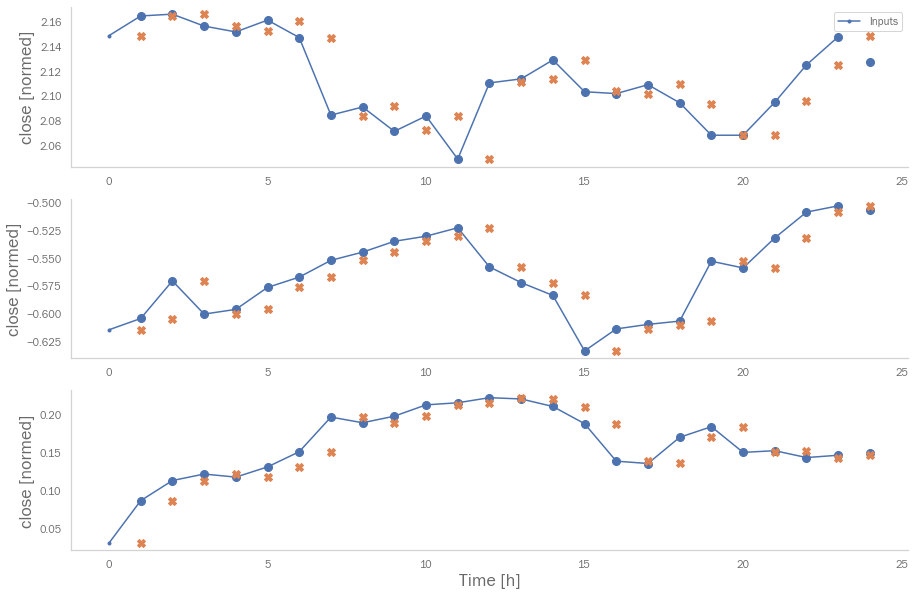

In [12]:
wide_window.plot(baseline)

In [13]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [14]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history


In [15]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test)


Epoch 1/20
192/192 [==============================] - 3s 10ms/step - loss: 0.8234 - mean_absolute_error: 0.6550 - val_loss: 2.5297 - val_mean_absolute_error: 1.5228
Epoch 2/20
192/192 [==============================] - 1s 7ms/step - loss: 0.4710 - mean_absolute_error: 0.4846 - val_loss: 1.3348 - val_mean_absolute_error: 1.1068
Epoch 3/20
192/192 [==============================] - 2s 8ms/step - loss: 0.2630 - mean_absolute_error: 0.3527 - val_loss: 0.6300 - val_mean_absolute_error: 0.7579
Epoch 4/20
192/192 [==============================] - 2s 9ms/step - loss: 0.1406 - mean_absolute_error: 0.2506 - val_loss: 0.2817 - val_mean_absolute_error: 0.5047
Epoch 5/20
192/192 [==============================] - 2s 8ms/step - loss: 0.0712 - mean_absolute_error: 0.1731 - val_loss: 0.1084 - val_mean_absolute_error: 0.3094
Epoch 6/20
130/192 [===================>..........] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.1238

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
single_step_window.plot(dense)

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
import IPython

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.val)
performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.test, verbose=0)


In [ ]:
conv_window.plot(multi_step_dense)


In [ ]:
# The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.
print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")


In [ ]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)


In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)
conv_window

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(conv_model)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["close"],
)

wide_conv_window


In [ ]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)


In [ ]:
wide_conv_window.plot(conv_model)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
    print(f"{name:8s}: {value[1]:0.4f}")
